## Automated inversion for porosity in shallow reservoirs using a Pseudo-Transient Adjoint solver for nonlinear hydro-mechanical equations
by G. Reuber, L. Holbach, L. Raess

publsihed ???

Journal of Computational Physics

Cite as ???

### Electronic supplement 1
This is a FEniCS (https://fenicsproject.org/) developed Finite element code to discretize the forward, adjoint and gradient equation for the 1D nonlinear diffusion equation as described by equations (41-52) in the main paper.



In [1]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

# --------- Domain --------- #
nx = 64                                # number of elements
L = 20                                 # total physical length of the domain
Lmin = -L/2+((L/(nx-1))/2)
Lmax =  L/2-((L/(nx-1))/2)
mesh = IntervalMesh(nx, Lmin, Lmax)    # define mesh with FEniCS
degr = 2                               # interprete all FEniCS Expressions with degree 2

# --------- Function spaces --------- #
Vu = FiniteElement("CG", mesh.ufl_cell(), 1)     # Use a linear continous Lagrangian element for the solution
W = FunctionSpace(mesh, Vu)
Q2 = FunctionSpace(mesh,"CG", 1)                 # Dummy function space for plotting

# --------- Boundary conditions --------- #
def boundary_left(x, on_boundary):
    return (x[0] < Lmin + 1e-10) and on_boundary

def boundary_right(x, on_boundary):
    return (x[0] > Lmax - 1e-10) and on_boundary

bcl  = DirichletBC(W, Constant(1), boundary_left)
bcr  = DirichletBC(W, Constant(0.5), boundary_right)
bcs = [bcl,bcr]

# --------- Forward solver Function  --------- #
def SolveForward(W, bcs, n, u, s):
    
    # Test and trial functions for nonlinear solver
    v  = TestFunction(W)
    du = TrialFunction(W) 
        
    F = (inner(grad(v),grad(u))*(u**n))*dx - (s*v)*dx     # note that this equation is nonlinear in u

    solve(F==0, u, bcs)

    print('     Forward solved ...')
    
    return u

# --------- Adjoint solver Function  --------- #
def SolveAdjoint(W, bcs, n, u, u_adj, u_obs):
    
    v = TestFunction(W) 
            
    F = (inner(grad(u_adj),(u**n*grad(v) + grad(u)*n*u**(n-1)*v)))*dx + (v)*dx   # note that this equation is linear in u
    
    solve(F==0, u_adj, bcs)

    print('     Adjoint solved ...')
    
    return u_adj

# --------- Gradient evaluation Function  --------- #
def ComputeGradientn(W, n, u_adj, u):
    
    # Mass matrix in parameter space
    mtrial = TrialFunction(W)
    mtest  = TestFunction(W)
    
    Mvarf = inner(mtrial, mtest) * dx
    M     = assemble(Mvarf)
    gradi = Function(W)
        
    gradj =  ((inner(grad(u_adj),grad(u))*(u**n*ln(abs(u))))*mtest)*dx
    
    MG = assemble(gradj)
    solve(M, gradi.vector(), MG)
      
    grad_norm2 = gradi.vector().inner(MG)
    gradnorm   = np.sqrt(grad_norm2)
    
    print('     Gradient evaluated ...')
    
    return gradi, gradnorm

     Forward solved ...
     Forward solved ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
     Adjoint solved ...
     Gradient evaluated ...
     Forward solved ...
     Adjoint solved ...
     Gradient evaluated ...
     Forward solved ...
     Adjoint solved ...
     Gradient evaluated ...
     Forward solved ...
     Adjoint solved ...
     Gradient evaluated ...


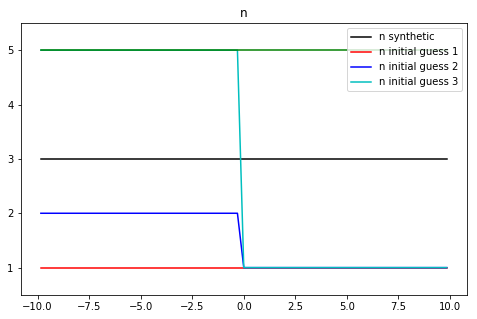

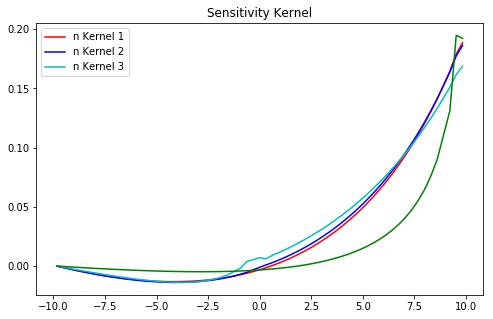

In [2]:
# --------- Initial conditions  --------- #
n = interpolate(Constant(3),W)
n_obs = n
s     = interpolate(Constant(0),W)

u_ini = Function(W)
u_ini.vector().set_local(np.random.rand(u_ini.vector().size())/10000 +1)  # to make Jacobian well posed
u_ini.vector().apply("")

# --------- Calculate synthetic data  --------- #
u       = SolveForward(W, bcs, n, u_ini, s)
u_obs   = interpolate(u, W)

# --------- Calculate Kernels for different initial guesses of n  --------- #
Kernels = np.zeros([4,nx+1])
ns      = np.zeros([4,nx+1])
for iKernel in range(4):
    
    if iKernel == 0:
        n       = interpolate(Constant(1),W)   # Homogeneous initial guess
    elif iKernel == 1:
        n       = interpolate(Expression('x[0]<0 ? 2:1',degree=degr),W)   # inhomogeneous initial guess underestimating
    elif iKernel == 2:
        n       = interpolate(Expression('x[0]<0 ? 5:1',degree=degr),W)   # inhomogeneous initial guess overestimating
    elif iKernel == 3:
        n       = interpolate(Constant(5),W)   # homogeneous initial guess overestimating
       
    # solve the forward problem
    u      = SolveForward(W, bcs, n, u_ini, s)

    # solve the adoint problem
    u_adj = SolveAdjoint(W, bcs, n, u, interpolate(Constant(0),W), u_obs)

    # evaluate the gradient (for the forward operator!)
    gradi, gradnorm = ComputeGradientn(W, n, u_adj, u)
    Kernels[iKernel,:] = gradi.vector().get_local()
    ns[iKernel,:]      = n.vector().get_local()

# --------- Plot --------- #
plt.figure(figsize=(8,5))
colors = ['k-','r-','b-','c-','g']
plt.plot(np.linspace(Lmin,Lmax,nx+1),np.flipud(n_obs.vector().get_local()),colors[0])
for ipl in range(4):
    plt.plot(np.linspace(Lmin,Lmax,nx+1),(ns[ipl,::-1]),colors[ipl+1])
axes = plt.gca()
axes.set_ylim([0.5,5.5])
plt.legend(['n synthetic','n initial guess 1','n initial guess 2','n initial guess 3'], loc='best')
plt.title('n')
plt.show()

plt.figure(figsize=(8,5))
for ipl in range(4):
    plt.plot(np.linspace(Lmin,Lmax,nx+1),(Kernels[ipl,::-1]),colors[ipl+1])
plt.legend(['n Kernel 1','n Kernel 2','n Kernel 3'], loc='best')
plt.title('Sensitivity Kernel')
plt.show()

np.savetxt('Kernels',Kernels)
np.savetxt('ns',ns)